In [1]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self): # when you try to print the object this function gets called
        return f"The value is {self.data}"

    
    '''
    gets executed when you call value objects like a + b where a and b are both Value object
    what python does under the hood is a.__add__(b) and a data accessible by self parameter and b accessible by other parameter
    '''
    '''
    for cases where there is multiple instances of same object is getting changed from different nodes such as
    d = a * b
    e = a + b
    f = d * e
    you need to be adding changes of derivative of each other instead of just overwritting which operation done first
    yt 1:26:34 
    '''

    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other) #making sure normal integers would also work work addition like b = a + 1
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            #derivate of addition is basically one. ex: y = x + z // dy/dx = 1 // applying chain rule also
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward 
            
        return out
    
    
    def __mul__(self, other): #basically same with add
        other = other if isinstance(other, Value) else Value(other) #making sure normal integers would also work work multiplication like b = a * 2
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            #derivate of mult is basically multiplant term. ex: y = x * z // dy/dx = z // applying chain rule also
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # throws assertionError when condition is false
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): #  b = a * 2 works but b = 2 * a doesnt work so this function will be fallback if mult function fails, it will look into here and switch the values
        return self * other
    def __radd__(self, other):
        return self + other
    def __truediv__(self, other): # showing of division with negative power
        return self * other ** -1 # this expression calls __pow__ function 
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other) # -other calls neg method
    
    def tanh(self):
        x = self.data
        res = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(res, (self, ), 'tanh')
        def _backward():
            #https://en.wikipedia.org/wiki/Hyperbolic_functions
            #derivate of tanh check the link. applying chain rule also
            self.grad += (1 - res**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backwards():
            self.grad += out.data * out.grad
        out._backward = _backwards
        return out
    
    
    def backward(self):
        topo = [] 
        visited = set() # this logic here very important becuase it prevents the instance where child root has 2 parents connected to it and one the parent also connected to other big parent
        #imagine this
        #if A node has child of b and c but c node has also child of b and d // b gets iterated again. 
        # look -3 2 -1 -2 value nodes from the ipad notes inside dir sussex
        def topoFunc(root):
            if root not in visited: # allows for aforomentioned situation
                visited.add(root) #gets all of nodes that are visited to prevent deiteration of same node and checking it in if condition
                for child in root._prev:
                    topoFunc(child) #iterates over every possible child of the subsequent nodes 
                topo.append(root) #when for loop above finished, it calls this root to be appended
        topoFunc(self) #iterating over selected root
        self.grad = 1.0 #this is important because start of the chain rule for first iteration, there should be some value passed to it top properly do chain rule
        #if it is 0 then no iteration can be done

        for x in reversed(topo): #we need to make backpropogation from top to bottom but returned array gives element from bottom to top so reverse is essential
            x._backward()


a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(1.0, label='c')
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
f = e ** 2; f.label = 'f'
g = f / b; g.label = 'g'
h = g - a; h.label = 'h'
h = h * 0.1
j = (2 * h).exp()
L = (j - 1) / (j + 1)
# L = h.tanh()

a = Value(2.0)
b = Value(4.0)
print(a / b)


The value is 0.5


In [2]:
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edge = set(), set() # btw even Values hold the same data attribute this set will be unique for every node created
    #because we didnt overwritten __eq__ method of value class and 
    #by default python initilazes unique identified for each object created
    def build(root):
        nodes.add(root)
        for child in root._prev: # getting all child elements of root
            edge.add((child, root)) # adding child element and its root as a tuple to establish the connection
            build(child) #re iterating over new root until there is no child element assosicated with root
    build(root)
    return nodes, edge

def draw_root(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) #making grapgh left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad), shape='record')
        if(n._op): 
            dot.node(uid + n._op, label=n._op) #we initiliaze this edge as a static string that can be referenced below
            dot.edge(uid + n._op, uid) #connecting to the result
    for x, y in edges:
        dot.edge(str(id(x)) , str(id(y)) + y._op) # connection to operator that initilized at top
    return dot

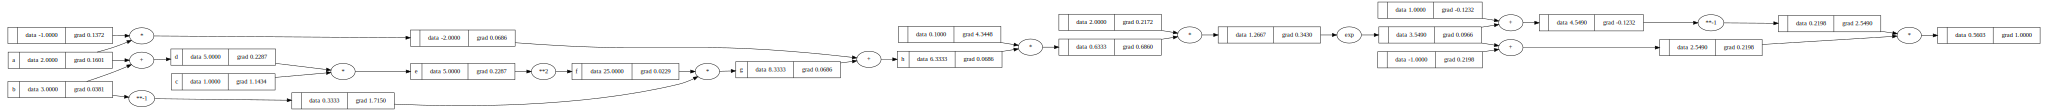

In [3]:
L.backward() #when re-run the values of gradient accumalete with previus values :) spend 1 hours to debug this...
draw_root(L)


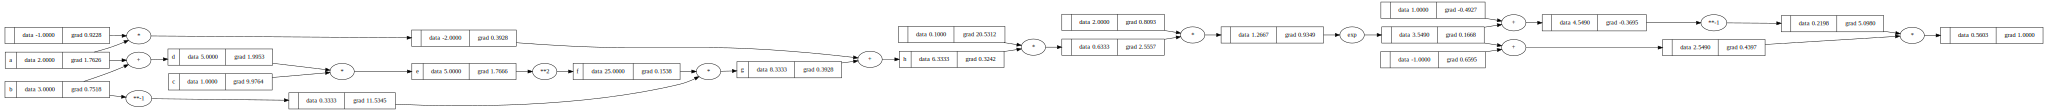

In [4]:
L.backward()
draw_root(L)


In [5]:
def lol():
    h = 0.001
    a = Value(2); a.label = 'a'
    b = Value(-3); b.label = 'b'
    c = Value(10); c.label = 'c'
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(0.1); f.label = 'f'
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2); a.label = 'a'
    b = Value(-3); b.label = 'b'
    c = Value(10); c.label = 'c'
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2); f.label = 'f'
    L = d * f; L.label = 'L'

    L2 = L.data + h
    print((L2 - L1) / h)

lol()


-8398.999999999998


In [6]:
import torch

In [7]:
x1 = torch.Tensor([2.0, 3.0]).double() #tensor has float 32 so converting python default of float 64
x1.requires_grad = True
x2 = torch.Tensor([3.0, 3.0]).double(); x2.requires_grad = True
x3 = torch.Tensor([1.0, 3.0]).double(); x3.requires_grad = True #just this tensor has some error but everything else is same so this work i guess
#these x1 x2 x3 called leaf nodes and by default they dont have grad field for efficiency purposes

x4 = x1 + x2; 
x5 = x4 * x3; 
x6 = x5 ** 2; 
x7 = x6 / x2; 
x8 = x7 - x1; 
x8 = x8 * 0.1; 
x9 = x8.tanh()
print(f'x9 value: {x9}')
print('---')
x9.backward()
print(f'x1 grad {x1.grad}')
print(f'x2 grad {x2.grad}')
print(f'x3 grad {x3.grad}')



x9 value: tensor([0.5603, 1.0000], dtype=torch.float64, grad_fn=<TanhBackward0>)
---


RuntimeError: grad can be implicitly created only for scalar outputs

In [594]:
'''
LETS START REAL NEURON STUFF
'''
import random


class Neuron:
    def __init__(self, nin): #number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):  #calling the object like n(x) where x can be anything, you can access the passed value by x
        # zip creates tuples with corresponding index of the given inputs ex:
        # x = [2.0, 3.0]; n = Neuron(2); n(x)
        # print(list(zip(self.w, x)))
        #this will output as
        #[(The value is -0.6962081713757258, 2.0), (The value is -0.4337539076098329, 3.0)]
        #important note: when one list pair given to zip is bigger than other, zip will be created based on small one length and discard the values of bigger one that exceeds the small list length
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        res = act.tanh()
        return res
    def parameters(self):
        return self.w + [self.b] # concatting lists with each other and making bias is also list for properly concat
    

class Layer:
    def __init__(self, nin, nout): #number of weights we want to assign to each neuron / how many neuron in one layer we want to create /// number of weights will be determined in mlp part based on number of neurons in previous layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x): # x is datas we want to assign to each neuron
        #ex; x = [2.0, 3.0]; n = Layer(2, 3); n(x) // creates 3 neurons with 2 weight assosicated with them (total 6 weight) and those weight assosicated with values given which is [2.0, 3.0]
        out = [n(x) for n in self.neurons]#returns results that are passed to neurons as a list, their activated values
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     out = neuron.parameters()
        #     params.extend(out) #basically same as append but append can add single value but extend can add list values
        # return params
        # this is one way to implement this but one liner approach to this is by
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # nin will be single data and to add it to nouts list, we convert it to list and then add them like normal addition
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))] # creating layers that correspond to each other in terms of neuron number.
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) #the result of the previous values are fed into layer as inputs for subsequient layers
            #gpt said It iterates over each layer in the MLP, passing the output of one layer as the input to the next.
            #chains the layers between each other by passing output of one layer as input of another
        return x #return last layer result
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    




In [613]:
x = [2.0, 3.0, -1.0] #input datas 
n = MLP(3, [4, 4, 1]) # 3 in and 4 4 1 layer of mlp where 1 is output layer
print(len(n.parameters())) #all of the bias and weight accumulated as their Value object
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] #training data
ys = [1.0, -1.0, -1.0, 1.0] #desired targets


41


In [615]:
for k in range(20):
    ypred = [n(x) for x in xs] #by calling this we basically started forward pass wehre every weight is multiplied by inputs
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) #basic root mean square error to calculate total error as a single value by taking output values and desired valuies and subtracting between each other and takings its squrare
    for f in n.parameters(): #this is very very common mistake. you should be always initilieze all of the paramaters grad value to 0 after completer backward process occur
        #because after each backward iteration, grad values of parameters accumulate from previos iteration and this would give you undesirable biig steps of approachin minima
        #see the bug i have tackled prevously at line 145
        #all grad values do += operation to previous grad values.
        #important term: it made us converge really fast 
        f.grad = 0.0
    loss.backward() #getting parameters grad values 
    draw_root(loss)

    for f in n.parameters():
        f.data += -0.05 * f.grad #0.05 is learning rate
    print(k, loss.data)



0 2.4077170940547816
1 1.1859587619911276
2 0.6444188465984118
3 0.40282663988051937
4 0.29228155210983753
5 0.23767485346755773
6 0.20031876622906786
7 0.17310429250483544
8 0.15238900036600161
9 0.13608995997414927
10 0.1229293179107245
11 0.11207940150891399
12 0.10298038517566785
13 0.0952399649867109
14 0.08857500542945874
15 0.08277600290301364
16 0.07768459081864362
17 0.0731788220232598
18 0.06916326094896069
19 0.0655621454979093


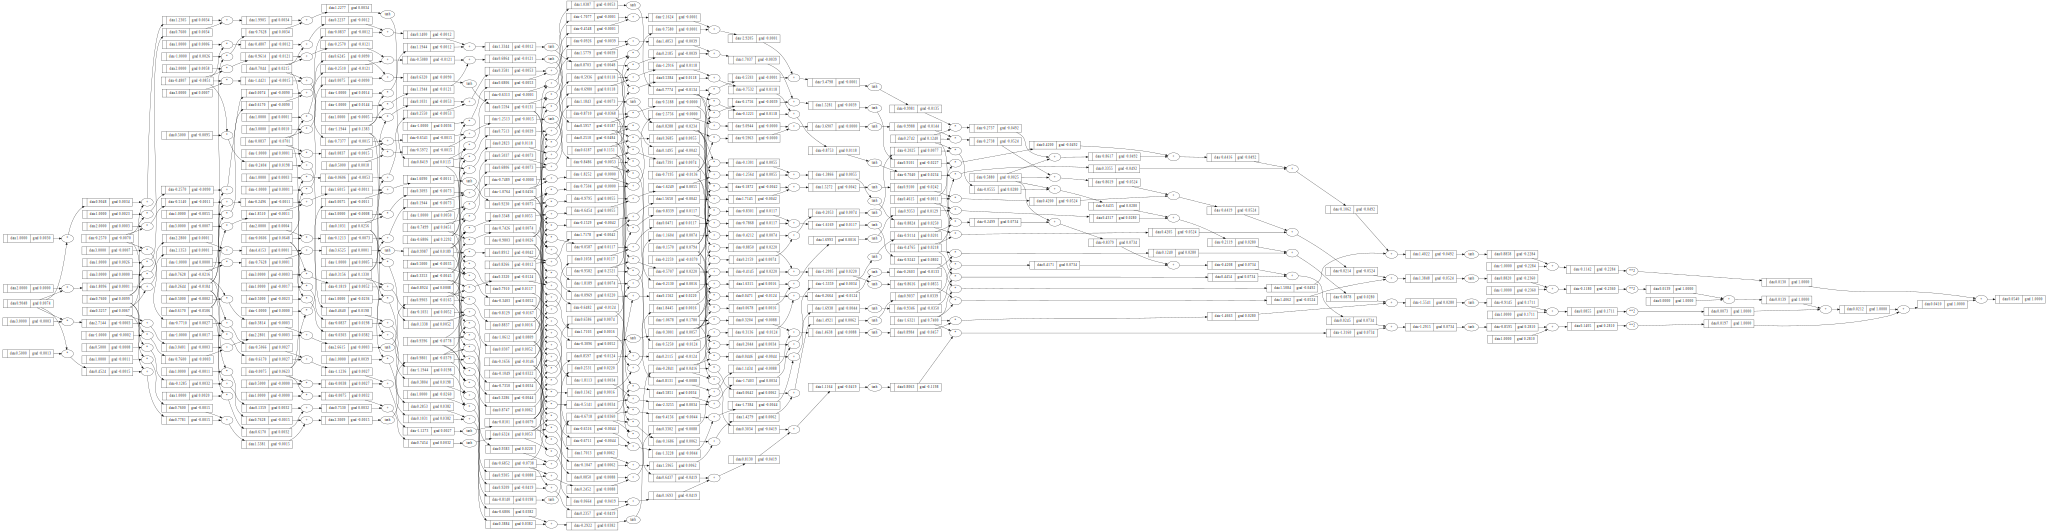

In [619]:
ypred = [n(x) for x in xs] #by calling this we basically started forward pass wehre every weight is multiplied by inputs
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) #basic root mean square error to calculate total error as a single value by taking output values and desired valuies and subtracting between each other and takings its squrare
loss.backward() #getting parameters grad values 
draw_root(loss)
